## Training Models

In this notebook, we will train different models on a given data set, and find the one that performs best

In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
fetch_housing_data()

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()

### Fix the categories in the categorical variable

In [5]:
d = {'<1H OCEAN':'LESS_1H_OCEAN', 'INLAND':'INLAND', 'ISLAND':'ISLAND', 'NEAR BAY':'NEAR_BAY', 'NEAR OCEAN':'NEAR_OCEAN'}
housing['ocean_proximity'] = housing['ocean_proximity'].map(lambda s: d[s])

### Add 2 more features

In [6]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["population_per_household"]=housing["population"]/housing["households"]

### Fix missing data

In [7]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True) 

### Create dummy variables based on the categorical variable

In [8]:
one_hot = pd.get_dummies(housing['ocean_proximity'])
housing = housing.drop('ocean_proximity', axis=1)
housing = housing.join(one_hot)

### Check the data

In [9]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 16 columns):
longitude                   20640 non-null float64
latitude                    20640 non-null float64
housing_median_age          20640 non-null float64
total_rooms                 20640 non-null float64
total_bedrooms              20640 non-null float64
population                  20640 non-null float64
households                  20640 non-null float64
median_income               20640 non-null float64
median_house_value          20640 non-null float64
rooms_per_household         20640 non-null float64
population_per_household    20640 non-null float64
INLAND                      20640 non-null uint8
ISLAND                      20640 non-null uint8
LESS_1H_OCEAN               20640 non-null uint8
NEAR_BAY                    20640 non-null uint8
NEAR_OCEAN                  20640 non-null uint8
dtypes: float64(11), uint8(5)
memory usage: 1.8 MB


### 1. Partition into train and test

Use train_test_split from sklearn.model_selection to partition the dataset into 70% for training and 30% for testing.

You can use the 70% for training set as both training and validation by using cross-validation.


In [10]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.3, random_state=42)

### Features

In [11]:
target = 'median_house_value'
features = list(train_set.columns)
features = [f for f in features if f!=target]

In [12]:
X_tr = train_set[features]
y_tr = train_set[[target]]

X_te = test_set[features]
y_te = test_set[[target]]

### 2. Polynomial transformations

Use PolynomialFeatures from sklearn.preprocessing

In [13]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
poly.fit(X_tr)
X_tr = poly.transform(X_tr)
X_te = poly.transform(X_te)

In [14]:
X_te.shape

(6192, 136)

##### You should obtain X_tr and X_te with 136 columns each, since originally you had 15 features.

##### With m original features, the new added polynomial features of degree 2 are: $(m^2-m)/2+m+1$. Why?

##### These, plus the original features gives a total of  $(m^2-m)/2+2m+1$

In [15]:
print("Original number of features: "+str(len(features)))
print("Final number of features: "+str(X_tr.shape[1]))

Original number of features: 15
Final number of features: 136


### 3. Scaling features

Similarly, use StandardScaler from sklearn.preprocessing to normalize the training and testing data, using the training data

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)

#### Comparing models

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())

### 4. Linear regression on original features (no transformations) --- benchmark

#### Your goal is to find the model that minimizes the rmse score

In [18]:
from sklearn.linear_model import LinearRegression
lin_scores = cross_val_score(LinearRegression(), train_set[features], train_set[target], scoring="neg_mean_squared_error", cv=4)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 70142.55721218  67456.39127204  67318.3258893   70866.26065275]
Mean: 68945.8837566


### 5. Linear regression  (on transformed features: polynomial transformation + scaling)

Now do as in 4 but with the original and transformed features (136 features)

In [19]:
lin_scores = cross_val_score(LinearRegression(), X_tr, y_tr, scoring="neg_mean_squared_error", cv=4)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [  1.09626586e+16   2.09837264e+15   1.10535405e+15   9.35143630e+13]
Mean: 3.56497491876e+15


If the error on the cross-validation is too high it is because the model is over-fitting. Regularization is needed.

### 6. Ridge regression

In [20]:
from sklearn.linear_model import Ridge
param_grid = [{'alpha': [0.001,0.01,0.1,1,10,100,1000,1000]}]
grid_search_rr = GridSearchCV(Ridge(), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search_rr.fit(X_tr, y_tr)

GridSearchCV(cv=3, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [21]:
print(grid_search_rr.best_params_)
print(np.sqrt(-grid_search_rr.best_score_))

{'alpha': 1000}
67204.1530043


### 7. Lasso regression

Now do the same as in 6 but with Lasso

In [22]:
from sklearn.linear_model import Lasso
param_grid = [{'alpha': [0.001,0.01,0.1,1,10,100,1000,10000]}]
grid_search_lr = GridSearchCV(Lasso(), param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)
grid_search_lr.fit(X_tr, y_tr)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] alpha=0.001 .....................................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


[CV] ...................................... alpha=0.001, total=   5.0s
[CV] alpha=0.001 .....................................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ...................................... alpha=0.001, total=   4.8s
[CV] alpha=0.001 .....................................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ...................................... alpha=0.001, total=   3.6s
[CV] alpha=0.01 ......................................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ....................................... alpha=0.01, total=   3.9s
[CV] alpha=0.01 ......................................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ....................................... alpha=0.01, total=   4.2s
[CV] alpha=0.01 ......................................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ....................................... alpha=0.01, total=   3.2s
[CV] alpha=0.1 .......................................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ........................................ alpha=0.1, total=   3.9s
[CV] alpha=0.1 .......................................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ........................................ alpha=0.1, total=   5.7s
[CV] alpha=0.1 .......................................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ........................................ alpha=0.1, total=   7.2s
[CV] alpha=1 .........................................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] .......................................... alpha=1, total=   6.1s
[CV] alpha=1 .........................................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] .......................................... alpha=1, total=   5.0s
[CV] alpha=1 .........................................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] .......................................... alpha=1, total=   3.6s
[CV] alpha=10 ........................................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......................................... alpha=10, total=   3.1s
[CV] alpha=10 ........................................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......................................... alpha=10, total=   3.9s
[CV] alpha=10 ........................................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......................................... alpha=10, total=   3.8s
[CV] alpha=100 .......................................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ........................................ alpha=100, total=   2.9s
[CV] alpha=100 .......................................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ........................................ alpha=100, total=   2.6s
[CV] alpha=100 .......................................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ........................................ alpha=100, total=   2.6s
[CV] alpha=1000 ......................................................
[CV] ....................................... alpha=1000, total=   1.6s
[CV] alpha=1000 ......................................................
[CV] ....................................... alpha=1000, total=   1.7s
[CV] alpha=1000 ......................................................
[CV] ....................................... alpha=1000, total=   1.3s
[CV] alpha=10000 .....................................................
[CV] ...................................... alpha=10000, total=   1.1s
[CV] alpha=10000 .....................................................
[CV] ...................................... alpha=10000, total=   1.1s
[CV] alpha=10000 .....................................................
[CV] ...................................... alpha=10000, total=   1.1s


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  1.4min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [23]:
print(grid_search_lr.best_params_)
print(np.sqrt(-grid_search_lr.best_score_))

{'alpha': 1000}
66619.6312718


### 8. Elastic Net regression

Do the same as in 6 and 7, but now with Elastic Net. However, the grid search should be over the parameters _alpha_ and  _l1_ratio_. Use just 3 values for l1_ratio. Make sure the values you use for this parameter make sense.

In [24]:
from sklearn.linear_model import ElasticNet
param_grid = [{'alpha': [0.001,0.01,0.1,1,10,100,1000,1000], 'l1_ratio': [0.2, 0.4, 0.6, 0.8]}]
grid_search_enr = GridSearchCV(ElasticNet(), param_grid, cv=3,scoring='neg_mean_squared_error', verbose=2)
grid_search_enr.fit(X_tr, y_tr)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] alpha=0.001, l1_ratio=0.2 .......................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV] ........................ alpha=0.001, l1_ratio=0.2, total=   3.2s
[CV] alpha=0.001, l1_ratio=0.2 .......................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ........................ alpha=0.001, l1_ratio=0.2, total=   3.1s
[CV] alpha=0.001, l1_ratio=0.2 .......................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ........................ alpha=0.001, l1_ratio=0.2, total=   3.2s
[CV] alpha=0.001, l1_ratio=0.4 .......................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ........................ alpha=0.001, l1_ratio=0.4, total=   3.1s
[CV] alpha=0.001, l1_ratio=0.4 .......................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ........................ alpha=0.001, l1_ratio=0.4, total=   3.0s
[CV] alpha=0.001, l1_ratio=0.4 .......................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ........................ alpha=0.001, l1_ratio=0.4, total=   3.1s
[CV] alpha=0.001, l1_ratio=0.6 .......................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ........................ alpha=0.001, l1_ratio=0.6, total=   3.0s
[CV] alpha=0.001, l1_ratio=0.6 .......................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ........................ alpha=0.001, l1_ratio=0.6, total=   3.1s
[CV] alpha=0.001, l1_ratio=0.6 .......................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ........................ alpha=0.001, l1_ratio=0.6, total=   3.1s
[CV] alpha=0.001, l1_ratio=0.8 .......................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ........................ alpha=0.001, l1_ratio=0.8, total=   3.1s
[CV] alpha=0.001, l1_ratio=0.8 .......................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ........................ alpha=0.001, l1_ratio=0.8, total=   3.1s
[CV] alpha=0.001, l1_ratio=0.8 .......................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ........................ alpha=0.001, l1_ratio=0.8, total=   3.1s
[CV] alpha=0.01, l1_ratio=0.2 ........................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......................... alpha=0.01, l1_ratio=0.2, total=   3.1s
[CV] alpha=0.01, l1_ratio=0.2 ........................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......................... alpha=0.01, l1_ratio=0.2, total=   3.1s
[CV] alpha=0.01, l1_ratio=0.2 ........................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......................... alpha=0.01, l1_ratio=0.2, total=   3.0s
[CV] alpha=0.01, l1_ratio=0.4 ........................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......................... alpha=0.01, l1_ratio=0.4, total=   3.1s
[CV] alpha=0.01, l1_ratio=0.4 ........................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......................... alpha=0.01, l1_ratio=0.4, total=   3.1s
[CV] alpha=0.01, l1_ratio=0.4 ........................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......................... alpha=0.01, l1_ratio=0.4, total=   3.1s
[CV] alpha=0.01, l1_ratio=0.6 ........................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......................... alpha=0.01, l1_ratio=0.6, total=   3.1s
[CV] alpha=0.01, l1_ratio=0.6 ........................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......................... alpha=0.01, l1_ratio=0.6, total=   3.2s
[CV] alpha=0.01, l1_ratio=0.6 ........................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......................... alpha=0.01, l1_ratio=0.6, total=   3.2s
[CV] alpha=0.01, l1_ratio=0.8 ........................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......................... alpha=0.01, l1_ratio=0.8, total=   3.1s
[CV] alpha=0.01, l1_ratio=0.8 ........................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......................... alpha=0.01, l1_ratio=0.8, total=   3.1s
[CV] alpha=0.01, l1_ratio=0.8 ........................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......................... alpha=0.01, l1_ratio=0.8, total=   3.0s
[CV] alpha=0.1, l1_ratio=0.2 .........................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] .......................... alpha=0.1, l1_ratio=0.2, total=   3.3s
[CV] alpha=0.1, l1_ratio=0.2 .........................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] .......................... alpha=0.1, l1_ratio=0.2, total=   3.2s
[CV] alpha=0.1, l1_ratio=0.2 .........................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] .......................... alpha=0.1, l1_ratio=0.2, total=   3.3s
[CV] alpha=0.1, l1_ratio=0.4 .........................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] .......................... alpha=0.1, l1_ratio=0.4, total=   3.2s
[CV] alpha=0.1, l1_ratio=0.4 .........................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] .......................... alpha=0.1, l1_ratio=0.4, total=   3.1s
[CV] alpha=0.1, l1_ratio=0.4 .........................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] .......................... alpha=0.1, l1_ratio=0.4, total=   5.2s
[CV] alpha=0.1, l1_ratio=0.6 .........................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] .......................... alpha=0.1, l1_ratio=0.6, total=   5.5s
[CV] alpha=0.1, l1_ratio=0.6 .........................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] .......................... alpha=0.1, l1_ratio=0.6, total=   9.9s
[CV] alpha=0.1, l1_ratio=0.6 .........................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] .......................... alpha=0.1, l1_ratio=0.6, total=   7.9s
[CV] alpha=0.1, l1_ratio=0.8 .........................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] .......................... alpha=0.1, l1_ratio=0.8, total=   4.4s
[CV] alpha=0.1, l1_ratio=0.8 .........................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] .......................... alpha=0.1, l1_ratio=0.8, total=   3.6s
[CV] alpha=0.1, l1_ratio=0.8 .........................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] .......................... alpha=0.1, l1_ratio=0.8, total=   5.2s
[CV] alpha=1, l1_ratio=0.2 ...........................................
[CV] ............................ alpha=1, l1_ratio=0.2, total=   2.1s
[CV] alpha=1, l1_ratio=0.2 ...........................................
[CV] ............................ alpha=1, l1_ratio=0.2, total=   2.1s
[CV] alpha=1, l1_ratio=0.2 ...........................................
[CV] ............................ alpha=1, l1_ratio=0.2, total=   1.9s
[CV] alpha=1, l1_ratio=0.4 ...........................................
[CV] ............................ alpha=1, l1_ratio=0.4, total=   1.8s
[CV] alpha=1, l1_ratio=0.4 ...........................................
[CV] ............................ alpha=1, l1_ratio=0.4, total=   1.9s
[CV] alpha=1, l1_ratio=0.4 ...........................................
[CV] ............................ alpha=1, l1_ratio=0.4, total=   1.7s
[CV] alpha=1, l1_ratio=0.6 ...........................................
[CV] .

/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ............................ alpha=1, l1_ratio=0.8, total=   9.4s
[CV] alpha=1, l1_ratio=0.8 ...........................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ............................ alpha=1, l1_ratio=0.8, total=  12.5s
[CV] alpha=1, l1_ratio=0.8 ...........................................


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ............................ alpha=1, l1_ratio=0.8, total=   5.1s
[CV] alpha=10, l1_ratio=0.2 ..........................................
[CV] ........................... alpha=10, l1_ratio=0.2, total=   0.2s
[CV] alpha=10, l1_ratio=0.2 ..........................................
[CV] ........................... alpha=10, l1_ratio=0.2, total=   0.2s
[CV] alpha=10, l1_ratio=0.2 ..........................................
[CV] ........................... alpha=10, l1_ratio=0.2, total=   0.2s
[CV] alpha=10, l1_ratio=0.4 ..........................................
[CV] ........................... alpha=10, l1_ratio=0.4, total=   0.3s
[CV] alpha=10, l1_ratio=0.4 ..........................................
[CV] ........................... alpha=10, l1_ratio=0.4, total=   0.3s
[CV] alpha=10, l1_ratio=0.4 ..........................................
[CV] ........................... alpha=10, l1_ratio=0.4, total=   0.3s
[CV] alpha=10, l1_ratio=0.6 ..........................................
[CV] .

[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:  3.2min finished


/Users/sayyed/anaconda/envs/faster-rcnn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


GridSearchCV(cv=3, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1000], 'l1_ratio': [0.2, 0.4, 0.6, 0.8]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [25]:
print(grid_search_enr.best_params_)
print(np.sqrt(-grid_search_enr.best_score_))

{'alpha': 0.1, 'l1_ratio': 0.4}
67072.6769846


### Evaluating your best model on TESTING data

Choose among grid_search_rr, grid_search_lr, and grid_search_enr, the model with best performance

In [26]:
from sklearn.metrics import mean_squared_error

final_model = grid_search_lr.best_estimator_   
y_te_estimation = final_model.predict(X_te)
final_mse = mean_squared_error(y_te, y_te_estimation)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

66772.8551745


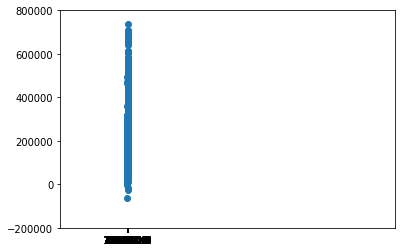

In [27]:
import matplotlib.pyplot as plt

plt.scatter(x=y_te, y=y_te_estimation)
plt.xlim([-200000,800000])
plt.ylim([-200000,800000])
plt.show()

### Question: Before you computed the final_rmse on the test data, what was your expected value for this quantity? Does your best model have high variance?

### Answer:

The expected value for the final rmse on the testing data should be the average rmse across the 3 folds of the best model, which was 66619. If these 2 values (expected 66619 and testing rmse 66772) are close, then the model does not have high variance.